In [56]:
import pandas as pd
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, average_precision_score
)

In [ ]:
file_path = 'mimic_readmission_features.csv'
mimic_dataset = pd.read_csv(file_path)
print(mimic_dataset.shape)
mimic_dataset.head()

# 1. Impute missing data

In [21]:
def explore_missing_data(df):
    """Explore and understand missing data patterns"""
    
    # Calculate missing percentages
    missing_stats = pd.DataFrame({
        'feature': df.columns,
        'missing_count': df.isnull().sum(),
        'missing_percent': (df.isnull().sum() / len(df)) * 100,
        'data_type': df.dtypes
    })
    
    missing_stats = missing_stats[missing_stats['missing_count'] > 0].sort_values('missing_percent', ascending=False)
    
    print(f"Features with missing data: {len(missing_stats)}")
    print("\nTop 10 features with most missing data:")
    print(missing_stats.head(10)[['feature', 'missing_count', 'missing_percent']])
    
    # Focus on lab values (our main concern)
    #lab_features = missing_stats[missing_stats['feature'].str.endswith('_mean')]
    
    return missing_stats

In [22]:
missing_analysis = explore_missing_data(mimic_dataset)

Features with missing data: 16

Top 10 features with most missing data:
                           feature  missing_count  missing_percent
phosphate_mean      phosphate_mean          78593        32.178595
calcium_mean          calcium_mean          77457        31.713479
magnesium_mean      magnesium_mean          74381        30.454062
glucose_mean          glucose_mean          62340        25.524075
bicarbonate_mean  bicarbonate_mean          62026        25.395513
aniongap_mean        aniongap_mean          61989        25.380364
chloride_mean        chloride_mean          60761        24.877579
sodium_mean            sodium_mean          60530        24.783000
potassium_mean      potassium_mean          59861        24.509089
urea_mean                urea_mean          59721        24.451769


In [23]:
def create_missingness_indicators(df):
    """Create binary features for 'was this test ordered?'"""
    
    df_with_indicators = df.copy()
    lab_cols = [col for col in df.columns if col.endswith('_mean')]
    
    print(f"Creating missingness indicators for {len(lab_cols)} lab tests...")
    
    indicators_created = []
    
    for lab_col in lab_cols:
        # Create indicator: 1 = lab was missing, 0 = lab was present
        indicator_name = lab_col.replace('_mean', '_was_missing')
        df_with_indicators[indicator_name] = df[lab_col].isnull().astype(int)
        indicators_created.append(indicator_name)
        
        # Show the split
        missing_count = df[lab_col].isnull().sum()
        present_count = df[lab_col].notnull().sum()
        
        print(f"  {lab_col.replace('_mean', '').upper():>12}: {missing_count:,} missing, {present_count:,} present")
    
    return df_with_indicators, indicators_created

In [24]:
dataset_with_indicators, indicator_features = create_missingness_indicators(mimic_dataset)

Creating missingness indicators for 15 lab tests...
      ANIONGAP: 61,989 missing, 182,251 present
   BICARBONATE: 62,026 missing, 182,214 present
       CALCIUM: 77,457 missing, 166,783 present
      CHLORIDE: 60,761 missing, 183,479 present
    CREATININE: 58,367 missing, 185,873 present
       GLUCOSE: 62,340 missing, 181,900 present
     MAGNESIUM: 74,381 missing, 169,859 present
     PHOSPHATE: 78,593 missing, 165,647 present
     POTASSIUM: 59,861 missing, 184,379 present
        SODIUM: 60,530 missing, 183,710 present
          UREA: 59,721 missing, 184,519 present
    HEMATOCRIT: 51,754 missing, 192,486 present
    HEMOGLOBIN: 55,498 missing, 188,742 present
      PLATELET: 54,635 missing, 189,605 present
           WBC: 55,790 missing, 188,450 present


In [27]:
def impute_lab_values_smart(df):
    """Impute missing lab values using clinical context
    Strategy: Use median values from similar patients (same age group)"""
    
    df_imputed = df.copy()
    
    # Create age groups for more clinical context
    df_imputed['age_group'] = pd.cut(
        df_imputed['age_at_admission'], 
        bins=[0, 40, 65, 80, 100], 
        labels=['Young (<40)', 'Middle (40-65)', 'Elderly (65-80)', 'Very Elderly (80+)']
    )
    
    print("\nAge group distribution:")
    print(df_imputed['age_group'].value_counts())
    
    # Impute each lab value
    lab_cols = [col for col in df.columns if col.endswith('_mean')]
    
    for lab_col in lab_cols:
        lab_name = lab_col.replace('_mean', '').upper()
        original_missing = df_imputed[lab_col].isnull().sum()
        
        if original_missing == 0:
            print(f"{lab_name:>12}: No missing values")
            continue
        
        # Impute by age group
        for age_group in df_imputed['age_group'].unique():
            if pd.isna(age_group):
                continue
                
            # Find missing values in this age group
            mask = (df_imputed['age_group'] == age_group) & df_imputed[lab_col].isnull()
            missing_in_group = mask.sum()
            
            if missing_in_group > 0:
                # Calculate median for this age group
                group_values = df_imputed[
                    (df_imputed['age_group'] == age_group) & df_imputed[lab_col].notnull()
                ][lab_col]
                
                if len(group_values) > 0:
                    group_median = group_values.median()
                    df_imputed.loc[mask, lab_col] = group_median
                else:
                    # Fallback to overall median
                    overall_median = df_imputed[lab_col].median()
                    df_imputed.loc[mask, lab_col] = overall_median
        
        # Double-check: fill any remaining missing with overall median
        remaining_missing = df_imputed[lab_col].isnull().sum()
        if remaining_missing > 0:
            overall_median = df_imputed[lab_col].median()
            df_imputed[lab_col] = df_imputed[lab_col].fillna(overall_median)
    
    # Remove temporary age group column
    df_imputed = df_imputed.drop('age_group', axis=1)
    
    return df_imputed

In [28]:
dataset_labs_imputed = impute_lab_values_smart(dataset_with_indicators)


Age group distribution:
age_group
Middle (40-65)        103637
Elderly (65-80)        58866
Young (<40)            53208
Very Elderly (80+)     28529
Name: count, dtype: int64


In [29]:
def handle_categorical_missing(df):
    """Handle missing values in categorical features"""
    
    df_final = df.copy()
    
    # Find categorical columns
    categorical_cols = df_final.select_dtypes(include=['object']).columns
    categorical_cols = [col for col in categorical_cols if col not in ['hadm_id', 'subject_id']]
    
    print(f"Categorical columns to check: {list(categorical_cols)}")
    
    for col in categorical_cols:
        missing_count = df_final[col].isnull().sum()
        
        if missing_count > 0:
            print(f"\n{col}:")
            print(f"  Missing values: {missing_count:,}")
            print(f"  Value counts:")
            print(f"    {df_final[col].value_counts()}")
            
            # Use mode (most common value) for imputation
            mode_value = df_final[col].mode()
            if len(mode_value) > 0:
                mode_value = mode_value.iloc[0]
                df_final[col] = df_final[col].fillna(mode_value)
                print(f"  Filled with mode: '{mode_value}'")
            else:
                df_final[col] = df_final[col].fillna('Unknown')
                print(f"  Filled with: 'Unknown'")
        else:
            print(f"{col}: No missing values ")
    
    return df_final

In [30]:
dataset_complete = handle_categorical_missing(dataset_labs_imputed)

Categorical columns to check: ['admission_type', 'insurance']
admission_type: No missing values 

insurance:
  Missing values: 4,157
  Value counts:
    insurance
Medicare     109874
Private       77574
Medicaid      46229
Other          6183
No charge       223
Name: count, dtype: int64
  Filled with mode: 'Medicare'


In [31]:
def validate_imputation(df_original, df_final):
    """Step 6: Validate that imputation worked correctly"""
    
    # Check for any remaining missing values
    remaining_missing = df_final.isnull().sum().sum()
    print(f"Remaining missing values: {remaining_missing}")
    
    if remaining_missing == 0:
        print("SUCCESS: No missing values remaining!")
    else:
        print("Still have missing values:")
        still_missing = df_final.isnull().sum()
        for col, count in still_missing[still_missing > 0].items():
            print(f"  {col}: {count:,} missing")
    
    # Show what we created
    original_features = df_original.shape[1]
    final_features = df_final.shape[1]
    new_features = final_features - original_features
    
    print(f"\nDataset transformation:")
    print(f"  Original features: {original_features}")
    print(f"  Final features: {final_features}")
    print(f"  New features added: {new_features} (missingness indicators)")
    
    # Show feature categories
    lab_original = len([col for col in df_original.columns if col.endswith('_mean')])
    lab_final = len([col for col in df_final.columns if col.endswith('_mean')])
    indicators = len([col for col in df_final.columns if col.endswith('_was_missing')])
    
    print(f"\nFeature breakdown:")
    print(f"  Lab values: {lab_final} (same as original: {lab_original})")
    print(f"  Missingness indicators: {indicators} (NEW)")
    print(f"  Other features: {final_features - lab_final - indicators}")
    
    return df_final

In [32]:
final_clean_dataset = validate_imputation(mimic_dataset, dataset_complete)

Remaining missing values: 0
SUCCESS: No missing values remaining!

Dataset transformation:
  Original features: 53
  Final features: 68
  New features added: 15 (missingness indicators)

Feature breakdown:
  Lab values: 15 (same as original: 15)
  Missingness indicators: 15 (NEW)
  Other features: 38


# 2. Preprare the data for splitting

In [33]:
def identify_feature_groups(df):
    """Organize features into logical groups for better understanding"""
    
    feature_groups = {
        'identifiers': [],
        'target': [],
        'demographics': [],
        'admission_details': [],
        'diagnoses': [],
        'lab_values': [],
        'lab_missing_indicators': []
    }
    
    for col in df.columns:
        if col in ['hadm_id', 'subject_id']:
            feature_groups['identifiers'].append(col)
        elif col == 'readmitted':
            feature_groups['target'].append(col)
        elif col in ['age_at_admission', 'gender_male', 'los_days']:
            feature_groups['demographics'].append(col)
        elif col.startswith('admission_type_') or col.startswith('insurance_'):
            feature_groups['admission_details'].append(col)
        elif col.startswith('diag_'):
            feature_groups['diagnoses'].append(col)
        elif col.endswith('_mean'):
            feature_groups['lab_values'].append(col)
        elif col.endswith('_was_missing'):
            feature_groups['lab_missing_indicators'].append(col)
    
    # Print summary
    total_features = 0
    for group, features in feature_groups.items():
        if group not in ['identifiers', 'target']:
            print(f"  {group.replace('_', ' ').title()}: {len(features)} features")
            total_features += len(features)
    
    print(f"Total modeling features: {total_features}")
    
    return feature_groups

In [34]:
feature_groups = identify_feature_groups(final_clean_dataset)
feature_groups

  Demographics: 3 features
  Admission Details: 0 features
  Diagnoses: 30 features
  Lab Values: 15 features
  Lab Missing Indicators: 15 features
Total modeling features: 63


{'identifiers': ['hadm_id', 'subject_id'],
 'target': ['readmitted'],
 'demographics': ['age_at_admission', 'gender_male', 'los_days'],
 'admission_details': [],
 'diagnoses': ['diag_I10',
  'diag_E785',
  'diag_K219',
  'diag_Z87891',
  'diag_I2510',
  'diag_F329',
  'diag_E119',
  'diag_N179',
  'diag_F419',
  'diag_I4891',
  'diag_E039',
  'diag_Z7901',
  'diag_Z794',
  'diag_D649',
  'diag_I129',
  'diag_G4733',
  'diag_I509',
  'diag_NoDx',
  'diag_J449',
  'diag_N390',
  'diag_E669',
  'diag_N189',
  'diag_Z20822',
  'diag_I252',
  'diag_E871',
  'diag_D62',
  'diag_Z66',
  'diag_F17200',
  'diag_G8929',
  'diag_Z8673'],
 'lab_values': ['aniongap_mean',
  'bicarbonate_mean',
  'calcium_mean',
  'chloride_mean',
  'creatinine_mean',
  'glucose_mean',
  'magnesium_mean',
  'phosphate_mean',
  'potassium_mean',
  'sodium_mean',
  'urea_mean',
  'hematocrit_mean',
  'hemoglobin_mean',
  'platelet_mean',
  'wbc_mean'],
 'lab_missing_indicators': ['aniongap_was_missing',
  'bicarbonate

In [35]:
import numpy as np

def prepare_modeling_data(df, feature_groups):
    feature_cols = []
    for group, features in feature_groups.items():
        if group not in ['identifiers', 'target']:
            feature_cols.extend(features)

    target_col = feature_groups['target']
    X = df[feature_cols].copy()
    y = df[target_col].copy()

    # Basic feature validation
    print(f"\nFeature Validation:")
    
    # Check for infinite values
    inf_cols = []
    for col in X.columns:
        if np.isinf(X[col]).any():
            inf_cols.append(col)
    
    if inf_cols:
        print(f"Found infinite values in: {inf_cols}")
        # Replace inf with NaN then forward fill
        X[inf_cols] = X[inf_cols].replace([np.inf, -np.inf], np.nan)
        X[inf_cols] = X[inf_cols].fillna(method='ffill').fillna(0)
    else:
        print("No infinite values found")
    
    # Check feature variance
    low_variance_cols = []
    for col in X.columns:
        if X[col].var() < 1e-8:
            low_variance_cols.append(col)
    
    if low_variance_cols:
        print(f"Low variance features: {len(low_variance_cols)} (consider removing)")
        # For tutorial, we'll keep them but note them
    else:
        print("All features have adequate variance")
    

    return X, y, feature_cols

# Prepare train/val/test splits
Split at patient level, stratify by readmission label

In [3]:
mimic_dataset.subject_id.nunique()

100000

In [ ]:
# prepare a metadata dataframe to split on subject_id and stratify by readmission label
patients_df = mimic_dataset[['subject_id', 'readmitted']]

In [37]:
from sklearn.model_selection import StratifiedGroupKFold

def split_patient_data(patients_df, final_clean_dataset, feature_groups):
    """
    Split patient data into train/validation/test sets ensuring no patient appears in multiple sets.
    
    This function performs a nested split:
    1. First split: separate test set (20% of patients)
    2. Second split: from remaining patients, create train/validation 
    
    Args:
        patients_df: DataFrame with patient metadata including 'subject_id' and 'readmitted'
        final_clean_dataset: Full dataset to be split
        feature_groups: Feature groups for modeling
        
    Returns:
        tuple: (X_train, y_train, X_val, y_val, X_test, y_test, feature_columns)
    """
    
    # Step 1: Creating initial train/test split
    main_splitter = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    main_splits = list(main_splitter.split(
        X=patients_df, 
        y=patients_df['readmitted'], 
        groups=patients_df['subject_id']
    ))
    
    # Get the first split
    train_val_ids, test_ids = main_splits[0]
    
    # Create metadata for train+validation patients and test patients
    train_val_meta = patients_df.iloc[train_val_ids]
    test_meta = patients_df.iloc[test_ids]
    
    print(f"Train+Val patients: {len(train_val_meta)}")
    print(f"Test patients: {len(test_meta)}")
    
    # Step 2: Creating train/validation split from remaining patients
    val_splitter = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=7)
    train_ids, val_ids = next(val_splitter.split(
        train_val_meta, 
        train_val_meta['readmitted'],
        train_val_meta['subject_id']
    ))
    
    # Create final metadata splits
    train_meta = train_val_meta.iloc[train_ids]
    val_meta = train_val_meta.iloc[val_ids]
    
    print(f"Final train patients: {len(train_meta)}")
    print(f"Validation patients: {len(val_meta)}")
    
    # Step 3: Filtering full dataset by patient groups
    df_train = final_clean_dataset[
        final_clean_dataset['subject_id'].isin(train_meta.subject_id.unique())
    ]
    df_val = final_clean_dataset[
        final_clean_dataset['subject_id'].isin(val_meta.subject_id.unique())
    ]
    df_test = final_clean_dataset[
        final_clean_dataset['subject_id'].isin(test_meta.subject_id.unique())
    ]
    
    print(f"Train records: {len(df_train)}")
    print(f"Validation records: {len(df_val)}")
    print(f"Test records: {len(df_test)}")
    
    #Step 4: Preparing modeling data
    X_train, y_train, feature_columns = prepare_modeling_data(df_train, feature_groups)
    X_val, y_val, _ = prepare_modeling_data(df_val, feature_groups)
    X_test, y_test, _ = prepare_modeling_data(df_test, feature_groups)
    
    # Verify no patient overlap between splits
    train_patients = set(train_meta.subject_id.unique())
    val_patients = set(val_meta.subject_id.unique())
    test_patients = set(test_meta.subject_id.unique())
    
    assert len(train_patients & val_patients) == 0, "Patient overlap between train and validation!"
    assert len(train_patients & test_patients) == 0, "Patient overlap between train and test!"
    assert len(val_patients & test_patients) == 0, "Patient overlap between validation and test!"
    
    return X_train, y_train, X_val, y_val, X_test, y_test, feature_columns

In [38]:
X_train, y_train, X_val, y_val, X_test, y_test, feature_columns = split_patient_data(
     patients_df, final_clean_dataset, feature_groups
 )

Train+Val patients: 196017
Test patients: 48223
Final train patients: 147187
Validation patients: 48830
Train records: 147187
Validation records: 48830
Test records: 48223

Feature Validation:
No infinite values found
All features have adequate variance

Feature Validation:
No infinite values found
All features have adequate variance

Feature Validation:
No infinite values found
All features have adequate variance


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
roc_auc_score, 
average_precision_score
)
import matplotlib.pyplot as plt
import warnings

import xgboost as xgb

warnings.filterwarnings('ignore')

def train_random_forest_model(X_train, y_train, X_val, y_val):
    """Train Random Forest - great for SHAP explanations"""
    
    print("Training Random Forest Model:")
    
    # Random Forest hyperparameters - can be tned later on
    rf_params = {
        'n_estimators': 100,       
        'max_depth': 10,         
        'min_samples_split': 20, 
        'min_samples_leaf': 10,   
        'max_features': 'sqrt', 
        'random_state': 42,    
        'n_jobs': -1       
    }
    
    # Train the model
    rf_model = RandomForestClassifier(**rf_params)
    
    print(f"\n  Training on {len(X_train):,} samples...")
    rf_model.fit(X_train, y_train)
    
    # Evaluate on validation set
    val_pred_proba = rf_model.predict_proba(X_val)[:, 1]
    
    val_auc = roc_auc_score(y_val, val_pred_proba)
    val_ap = average_precision_score(y_val, val_pred_proba)
    
    print(f"Training complete!")
    print(f"Validation AUC: {val_auc:.3f}")
    print(f"Validation AP: {val_ap:.3f}")
    
    return rf_model

def train_logistic_regression_model(X_train, y_train, X_val, y_val):
    """Train Logistic Regression - great for LIME explanations"""
    
    print("\nTraining Logistic Regression Model:")
    
    # Scale features for logistic regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Logistic regression parameters
    lr_params = {
        'random_state': 42,
        'max_iter': 1000,
        'class_weight': 'balanced'
    }
    
    # Train the model
    lr_model = LogisticRegression(**lr_params)
    
    print(f"\n  Training on {len(X_train):,} samples...")
    lr_model.fit(X_train_scaled, y_train)
    
    # Evaluate on validation set
    val_pred_proba = lr_model.predict_proba(X_val_scaled)[:, 1]
    
    val_auc = roc_auc_score(y_val, val_pred_proba)
    val_ap = average_precision_score(y_val, val_pred_proba)
    
    print(f"Training complete!")
    print(f"Validation AUC: {val_auc:.3f}")
    print(f"Validation AP: {val_ap:.3f}")
    
    return lr_model, scaler

def train_xgboost_model(X_train, y_train, X_val, y_val):
    """Train XGBoost - excellent for SHAP explanations and performance"""
    
    print("\nTraining XGBoost Model:")
    
    # Calculate scale_pos_weight for class imbalance
    negative_samples = len(y_train[y_train == 0])
    positive_samples = len(y_train[y_train == 1])
    scale_pos_weight = negative_samples / positive_samples
    
    # XGBoost hyperparameters optimized for healthcare
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 200,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42,
        'n_jobs': -1,
        'early_stopping_rounds': 20 
    }
    
    # Train the model with validation set
    xgb_model = xgb.XGBClassifier(**xgb_params)
    
    print(f"\n  Training with early stopping on validation set...")
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    print(f"  Best iteration: {xgb_model.best_iteration}")
    
    # Evaluate on validation set
    val_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
    
    val_auc = roc_auc_score(y_val, val_pred_proba)
    val_ap = average_precision_score(y_val, val_pred_proba)
    
    print(f" Training complete!")
    print(f" Validation AUC: {val_auc:.3f}")
    print(f"Validation AP: {val_ap:.3f}")
    
    return xgb_model

In [40]:
rf_model = train_random_forest_model(X_train, y_train, X_val, y_val)

Training Random Forest Model:

  Training on 147,187 samples...
Training complete!
Validation AUC: 0.639
Validation AP: 0.315


In [43]:
lr_model, scaler = train_logistic_regression_model(X_train, y_train, X_val, y_val)


Training Logistic Regression Model:

  Training on 147,187 samples...
Training complete!
Validation AUC: 0.635
Validation AP: 0.306


In [44]:
xgb_model = train_xgboost_model(X_train, y_train, X_val, y_val)


Training XGBoost Model:

  Training with early stopping on validation set...
  Best iteration: 82
 Training complete!
 Validation AUC: 0.652
Validation AP: 0.321


### Deep Neural Network

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score

In [47]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [48]:
def prepare_data_for_pytorch(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=256):
    """Prepare data specifically for PyTorch models"""
    
    print("Preparing data for PyTorch...")
    
    # Scale features for neural network
    scaler = StandardScaler()
    
    # Fit on training data only
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    
    y_train_tensor = torch.FloatTensor(y_train.values if hasattr(y_train, 'values') else y_train)
    y_val_tensor = torch.FloatTensor(y_val.values if hasattr(y_val, 'values') else y_val)
    y_test_tensor = torch.FloatTensor(y_test.values if hasattr(y_test, 'values') else y_test)
    
    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Data preparation complete:")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")
    print(f"Batch size: {batch_size}")
    
    return (train_loader, val_loader, test_loader, 
            X_train_tensor, X_val_tensor, X_test_tensor,
            y_train_tensor, y_val_tensor, y_test_tensor, scaler)


In [49]:
class ReadmissionPredictor(nn.Module):
    def __init__(self, input_size):
        super(ReadmissionPredictor, self).__init__()
        
        # Define the layers
        self.layer1 = nn.Linear(input_size, 64) 
        self.layer2 = nn.Linear(64, 32)        
        self.layer3 = nn.Linear(32, 16)        
        self.output = nn.Linear(16, 1)        
        
        # Activation function and dropout for regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Forward pass through the network
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        
        x = self.relu(self.layer3(x))
        x = self.dropout(x)
        
        x = self.sigmoid(self.output(x))
        
        return x

# Create the model
def create_model(input_size):
    model = ReadmissionPredictor(input_size)
    return model

In [50]:
def train_model(model, train_loader, num_epochs=100, learning_rate=0.001):
    """
    Train the neural network
    """
    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Track training progress
    train_losses = []
    
    print("Starting training...")
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        
        for batch_x, batch_y in train_loader:
            # Clear gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Calculate average loss for this epoch
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Print progress every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    print("Training completed!")
    return train_losses

In [ ]:
(train_loader, val_loader, test_loader, 
X_train_tensor, X_val_tensor, X_test_tensor,
            y_train_tensor, y_val_tensor, y_test_tensor, scaler) = prepare_data_for_pytorch(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=256)

In [ ]:
# Create the model
input_size = X_train.shape[1]
model = create_model(input_size)
    
# Train the model
train_losses = train_model(model, train_loader, num_epochs=100)

# Evaluate models

In [57]:
def evaluate_model_performance(model, X_test, y_test, model_name, scaler=None):
    """Comprehensive model evaluation"""
    
    print(f"\nEvaluating {model_name}:")
    
    # Apply scaling if needed (for logistic regression)
    if scaler is not None:
        X_test_processed = scaler.transform(X_test)
    else:
        X_test_processed = X_test
    
    # Make predictions
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    y_pred = model.predict(X_test_processed)
    
    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)
    ap_score = average_precision_score(y_test, y_pred_proba)
    
    print(f"Test AUC: {auc_score:.3f}")
    print(f"Test Average Precision: {ap_score:.3f}")
    
    # Classification report
    print(f"\nClassification Report:")
    report = classification_report(y_test, y_pred, output_dict=True)
    
    for class_name in ['0', '1']:
        class_label = 'No Readmission' if class_name == '0' else 'Readmission'
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        
        print(f"    {class_label:>15}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\nConfusion Matrix:")
    print(f"    True Negatives:  {tn:,}")
    print(f"    False Positives: {fp:,}")
    print(f"    False Negatives: {fn:,}")
    print(f"    True Positives:  {tp:,}")
    
    return {
        'auc': auc_score,
        'average_precision': ap_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'confusion_matrix': cm
    }



In [69]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
def evaluate_nn_model(model, X_test_tensor, y_test_tensor):
    """
    Evaluate the trained model
    """
    model.eval()
    
    with torch.no_grad(): 
        # Get predictions
        test_outputs = model(X_test_tensor)
        test_predictions = (test_outputs > 0.5).float()
        
        # Convert back to numpy for sklearn metrics
        y_pred = test_predictions.numpy().flatten()
        y_true = y_test_tensor.numpy().flatten()
        y_prob = test_outputs.numpy().flatten()
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_prob)
        ap_score = average_precision_score(y_test, y_prob)
        
        print("\n=== Model Performance ===")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC Score: {auc_score:.4f}")
        print("\nDetailed Classification Report:")
        print(classification_report(y_true, y_pred))
        
        return {
            'accuracy': accuracy,
            'auc': auc_score,
            'average_precision': ap_score,
            'predictions': y_pred,
            'probabilities': y_prob
        }

In [60]:
# Evaluate models
rf_results = evaluate_model_performance(rf_model, X_test, y_test, "Random Forest")
lr_results = evaluate_model_performance(lr_model, X_test, y_test, "Logistic Regression", scaler)
xgb_results = evaluate_model_performance(xgb_model, X_test, y_test, "XGBoost")


Evaluating Random Forest:
Test AUC: 0.634
Test Average Precision: 0.302

Classification Report:
     No Readmission: Precision=0.801, Recall=1.000, F1=0.890
        Readmission: Precision=0.714, Recall=0.001, F1=0.001

Confusion Matrix:
    True Negatives:  38,639
    False Positives: 2
    False Negatives: 9,577
    True Positives:  5

Evaluating Logistic Regression:
Test AUC: 0.624
Test Average Precision: 0.286

Classification Report:
     No Readmission: Precision=0.848, Recall=0.629, F1=0.723
        Readmission: Precision=0.267, Recall=0.546, F1=0.359

Confusion Matrix:
    True Negatives:  24,324
    False Positives: 14,317
    False Negatives: 4,354
    True Positives:  5,228

Evaluating XGBoost:
Test AUC: 0.644
Test Average Precision: 0.310

Classification Report:
     No Readmission: Precision=0.804, Recall=0.995, F1=0.889
        Readmission: Precision=0.519, Recall=0.022, F1=0.043

Confusion Matrix:
    True Negatives:  38,443
    False Positives: 198
    False Negatives: 9

In [70]:
# Evaluate the model
results_nn = evaluate_nn_model(model, X_test_tensor, y_test_tensor)


=== Model Performance ===
Accuracy: 0.7985
AUC Score: 0.6411

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.99      0.89     38641
         1.0       0.43      0.04      0.08      9582

    accuracy                           0.80     48223
   macro avg       0.62      0.51      0.48     48223
weighted avg       0.73      0.80      0.73     48223



In [67]:
results_nn

{'accuracy': 0.798519378719698,
 'auc': np.float64(0.6410930493121849),
 'predictions': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'probabilities': array([0.20669171, 0.38922617, 0.3761977 , ..., 0.2876305 , 0.12833232,
        0.26135865], dtype=float32)}

# Plot models performances

In [78]:
def plot_model_comparison(rf_results, lr_results, xgb_results, nn_results, y_test):
    """Create comparison plots for both models"""
    
    print(f"\n📈 Creating Model Comparison Plots...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # ROC Curves
    ax1 = axes[0, 0]
    
    # Random Forest ROC
    rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_results['probabilities'])
    ax1.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC={rf_results["auc"]:.3f})', linewidth=2)
    
    # Logistic Regression ROC  
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_results['probabilities'])
    ax1.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC={lr_results["auc"]:.3f})', linewidth=2)

    # XGBoost ROC
    xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_results['probabilities'])
    ax1.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC={xgb_results["auc"]:.3f})', linewidth=2)
    
    # NN ROC
    nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_results['probabilities'])
    ax1.plot(nn_fpr, nn_tpr, label=f'Deep Neural Network (AUC={nn_results["auc"]:.3f})', linewidth=2)

    # Diagonal line
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves - Model Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Precision-Recall Curves
    ax2 = axes[0, 1]
    
    # Random Forest PR
    rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_results['probabilities'])
    ax2.plot(rf_recall, rf_precision, label=f'Random Forest (AP={rf_results["average_precision"]:.3f})', linewidth=2)
    
    # Logistic Regression PR
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_results['probabilities'])
    ax2.plot(lr_recall, lr_precision, label=f'Logistic Regression (AP={lr_results["average_precision"]:.3f})', linewidth=2)
    
    # XGBoost PR
    xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_results['probabilities'])
    ax2.plot(xgb_recall, xgb_precision, label=f'XGBoost (AP={xgb_results["average_precision"]:.3f})', linewidth=2)

    # Deep Neural Network PR
    nn_precision, nn_recall, _ = precision_recall_curve(y_test, nn_results['probabilities'])
    ax2.plot(nn_recall, nn_precision, label=f'XGBoost (AP={nn_results["average_precision"]:.3f})', linewidth=2)
    
    # Baseline
    baseline = float(y_test.mean())
    ax2.axhline(y=baseline, color='k', linestyle='--', alpha=0.5, label=f'Baseline ({baseline:.3f})')
    
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curves')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Feature Importance (Random Forest only)
    ax3 = axes[1, 0]
    
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=True).tail(15)
    
    ax3.barh(range(len(feature_importance)), feature_importance['importance'])
    ax3.set_yticks(range(len(feature_importance)))
    ax3.set_yticklabels(feature_importance['feature'])
    ax3.set_xlabel('Feature Importance')
    ax3.set_title('Top 15 Features - Random Forest')
    ax3.grid(True, alpha=0.3)
    
    # Model Performance Summary
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    summary_text = f"""
    MODEL PERFORMANCE SUMMARY
    
    Random Forest:
    • AUC: {rf_results['auc']:.3f}
    • Average Precision: {rf_results['average_precision']:.3f}
    
    Logistic Regression:
    • AUC: {lr_results['auc']:.3f}  
    • Average Precision: {lr_results['average_precision']:.3f}

    XGBoost:
    • AUC: {xgb_results['auc']:.3f}  
    • Average Precision: {xgb_results['average_precision']:.3f}

    Deep Neural Network:
    • AUC: {nn_results['auc']:.3f}  
    • Average Precision: {nn_results['average_precision']:.3f}

    """
    
    ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.savefig('model_comparison_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Plots saved as 'model_comparison_plots.png'")




📈 Creating Model Comparison Plots...


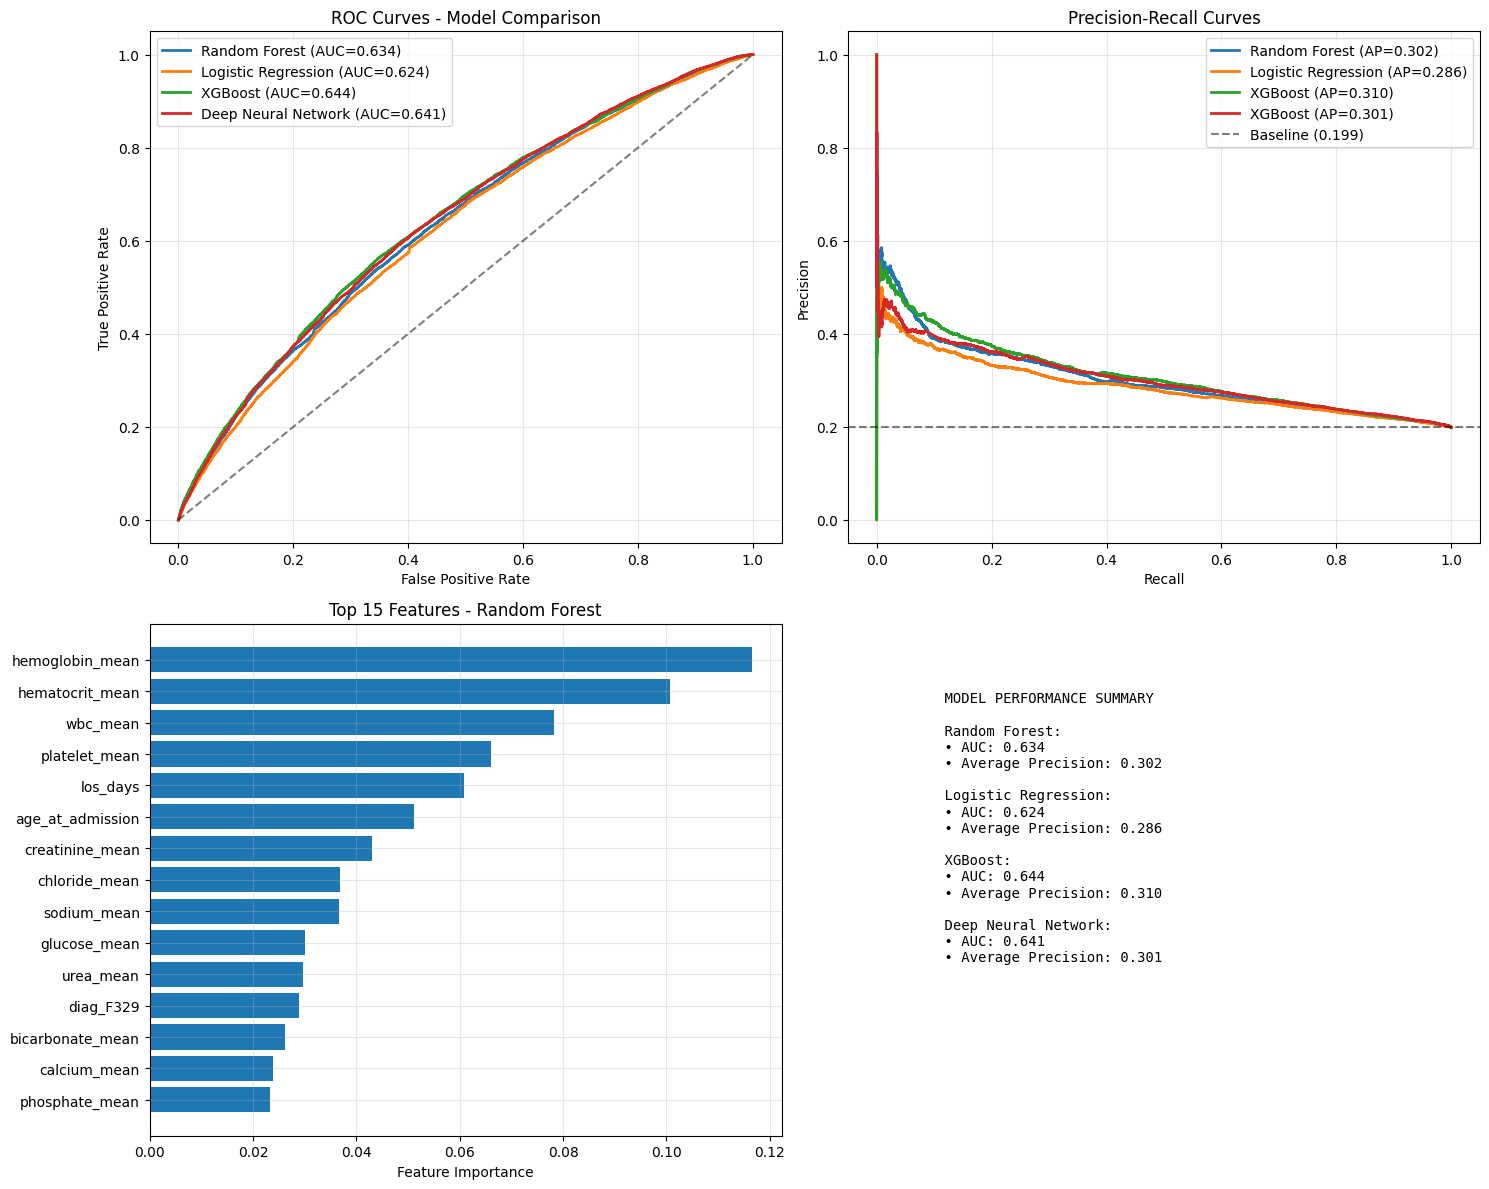

Plots saved as 'model_comparison_plots.png'


In [79]:

# Create comparison plots with all three models
plot_model_comparison(rf_results, lr_results, xgb_results, results_nn, y_test)

In [80]:
def save_models_and_data(rf_model, lr_model, xgb_model, nn_model, scaler, X_test, y_test, feature_columns, feature_groups):
    """Save everything needed for SHAP and LIME explanations"""
    
    import pickle
    
    print("Saving models and data for explanation phase...")
    
    # Save models
    with open('random_forest_model.pkl', 'wb') as f:
        pickle.dump(rf_model, f)
    
    with open('logistic_regression_model.pkl', 'wb') as f:
        pickle.dump(lr_model, f)

    with open('xgboost_model.pkl', 'wb') as f:
        pickle.dump(xgb_model, f)

    with open('nn_model.pkl', 'wb') as f:
        pickle.dump(nn_model, f)
    
    with open('feature_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    
    # Save test data for explanations
    X_test.to_csv('X_test_for_explanations.csv', index=False)
    y_test.to_csv('y_test_for_explanations.csv', index=False)
    
    # Save feature information
    feature_info = {
        'feature_columns': feature_columns,
        'feature_groups': feature_groups,
    }
    
    import json
    with open('model_info.json', 'w') as f:
        json.dump(feature_info, f, indent=2, default=str)



In [82]:
# Save everything
save_models_and_data(rf_model, lr_model, xgb_model, model, scaler, X_test, y_test, feature_columns, feature_groups)

Saving models and data for explanation phase...
